In [37]:
import os
import time
import shutil

In [ ]:
# os.environ['CUDA_VISIBLE_DEVICES']='4'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

In [ ]:
# import jax
# print(jax.devices())

2024-10-31 09:35:44.286129: I external/tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 09:35:44.441889: I external/tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 09:35:44.442796: I external/tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 09:35:44.714476: I external/tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
CUDA backend failed to initialize: Unable to load CUDA. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]


In [4]:
import numpy as onp

import jax.numpy as np
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition

from functools import partial
import time

f32 = np.float32
f64 = np.float64
  
key = random.PRNGKey(0)

In [5]:
#从TMalign输出中获取得分
def getscore(file):
    cnt=0
    score=0.0
    with open(file) as f:
        for i in f:
            #print(cnt,i)
            if cnt==14:
                xi=i.split()
                score=float(xi[1])
                break
            cnt=cnt+1
    return score

In [6]:
#成对距离的计算
from jax_md import space
import jax.numpy as np
def displacement(Ra, Rb, **unused_kwargs):
    dR = Ra - Rb
    return dR
metric = space.metric(displacement)
metrix = space.map_product(metric)

In [7]:
#酶和小分子的读入
from biopandas.pdb import PandasPdb
def readlig(file):
    data = PandasPdb().read_pdb(file)
    df = data.df['HETATM']
    typ=df['atom_name']
    lx=df['x_coord']
    ly=df['y_coord']
    lz=df['z_coord']
    osym=df['element_symbol']
    otyp=[]
    opos=[]
    for i in range(len(typ)):
        otyp.append(typ[i])
        opos.append([lx[i],ly[i],lz[i]])
    
    nom=['CHA', 'CHB', 'CHC', 'CHD', 'C1A', 'C2A', 'C3A', 'C4A', 'CMA', 'CAA', 'CBA', 'CGA', 'O1A', 'O2A', 'C1B', 'C2B', 'C3B', 'C4B', 'CMB', 'CAB', 'CBB', 'C1C', 'C2C', 'C3C', 'C4C', 'CMC', 'CAC', 'CBC', 'C1D', 'C2D', 'C3D', 'C4D', 'CMD', 'CAD', 'CBD', 'CGD', 'O1D', 'O2D', 'NA', 'NB', 'NC', 'ND', 'FE']
    if len(otyp)!=43:
        return otyp,opos
#    if otyp[0]!=nom[0]:
    dic={}
    new_pos=[]
    new_typ=[]
    new_sym=[]
    for i in range(len(otyp)):
        dic[otyp[i]]=i
    for i in nom:
        j=dic[i]
        new_pos.append(opos[j])
        new_typ.append(otyp[j])
        new_sym.append(osym[j])
    return new_typ,new_pos,new_sym
    
    return otyp,opos,osym

def readrec(file):
    data = PandasPdb().read_pdb(file)
    df = data.df['ATOM']
    res=df['residue_name']
    typ=df['atom_name']
    lx=df['x_coord']
    ly=df['y_coord']
    lz=df['z_coord']
    sym=df['element_symbol']
    otyp=[]
    opos=[]
    ores=[]
    osym=[]
    for i in range(len(typ)):
        otyp.append(typ[i])
        opos.append([lx[i],ly[i],lz[i]])
        ores.append(res[i])
        osym.append(sym[i])
    return otyp,opos,ores,osym

In [8]:
def readrecx(file):
    data = PandasPdb().read_pdb(file)
    df = data.df['ATOM']
    #print(df)
    res=df['residue_name']
    resnum=df['residue_number']
    typ=df['atom_name']
    lx=df['x_coord']
    ly=df['y_coord']
    lz=df['z_coord']
    sym=df['element_symbol']
    otyp=[]
    opos=[]
    ores=[]
    osym=[]
    onum=[]
    for i in range(len(typ)):
        otyp.append(typ[i])
        opos.append([lx[i],ly[i],lz[i]])
        ores.append(res[i])
        osym.append(sym[i])
        onum.append(resnum[i])
    return otyp,opos,ores,osym,onum

In [9]:
dicr={'H':0.32,'C':0.77,'N':0.75,'O':0.73,'S':1.02,'FE':0.76}
def ckcrash(pres,ps,ppos,hs,hpos):
    #检查蛋白质和小分子关系，p代表蛋白质数据，h代表小分子数据
    
    #生成原子半径
    pr=[]
    hr=[]
    for i in ps:
        if i not in dicr:
            #print(i,dicr)
            return
        pr.append(dicr[i])
    for i in hs:
        if i not in dicr:
            #print(i,dicr)
            return
        hr.append(dicr[i])
    
    
    pr=np.array(pr)
    hr=np.array(hr)
    ppos=np.array(ppos)
    hpos=np.array(hpos)
    disph=[]
    result='success'
    minfes=100.0
    spos=0
    
    #计算heme小分子的原子与蛋白质原子的距离
    for i in range(len(hs)):
        dis=metric(hpos[i],ppos)-(pr+hr[i])
        disph.append(np.min(dis))
        if hs[i]=='FE':
            for j in range(len(pr)):
                if ps[j]=='S': #and pres[j]=='CYS':
                    fes=dis[j]+pr[j]+hr[i]
                    #print(fes)
                    if fes<minfes:
                        minfes=fes
                        spos=j
            if minfes<1.93 or minfes>2.77:
                result='Fe_remote'

    for i in disph:
        if i<0:
            result='crash'
            break
        if i>11:
            result='notin'
            break

    return disph,result,minfes,spos

In [10]:
def process(rfile,lfile):
    #检查蛋白质和小分子的具体关系，rfile代表蛋白质数据路径，lfile代表小分子数据路径
    ptyp,ppos,pres,psym=readrec(rfile)
    ltyp,lpos,lsym=readlig(lfile)
    mindis,result,minfes,spos=ckcrash(pres,psym,ppos,lsym,lpos)
    return result,minfes,spos
    #print(minfes,min(mindis))
    if result!='crash':
        return result,minfes,spos
    #检查具体的crash情况
    nl=[ 'CBA', 'CGA', 'O1A', 'O2A',  'CBB', 'CBC', 'CBD', 'CGD', 'O1D', 'O2D'] 
    mintag=0
    crashl=[]
    for i in range(len(mindis)):
        if mindis[i]<0:
            if ltyp[i] not in nl:
                mintag=1
            crashl.append(ltyp[i])
    if mintag==0:
        return 'rotate',minfes,spos
    if len(crashl)==1 and crashl[0]=='FE':
        return 'Fe_crash',minfes,spos
    return 'other',minfes,spos

In [11]:
def checkbondhem(ligfile):
    conext=0
    with open(ligfile) as f:
        for i in f:
            xi=i.split()
            if xi[0]=='CONECT':
                conext=1
                break
    return conext

In [12]:
def get_tem(blv,top,i):
    pat='./alfpdb/alf'+str(i)
    fdsk=pat+'/foldseekout.txt'
    teml=[]
    with open(fdsk)as f:
        for j in f:
            xi=j.split()
            out=xi[1].replace("'", "").replace(",", "")
            tpp='./templete/'+out
            ligp=tpp+'/lig.pdb'
            if checkbondhem(ligp)==0:
                continue
            teml.append(tpp)
            if len(teml)>20:
                break
    
    if blv==1:
        outl=[]
        for j in range(top):
            outl.append(teml[j])
        return outl
    
    if blv==0:
        prt='./alfpdb/alf'+str(i)+'/apdb.pdb'
        outf='outtmxra.txt'
        rel=[]
        for j in range(20):
            tem=teml[j]+'/rec.pdb'
            #print(prt,tem)
            com='./TMalign '+prt+' '+tem+' > '+outf
            os.system(com)
            sc=getscore(outf)
            rel.append((teml[j],sc))
        sortedl=sorted(rel,key=lambda x:x[1],reverse=True)
        outl=[]
        for j in range(top):
            outl.append(sortedl[j][0])
        return outl
        #print(sortedl)
    
#print(get_tem(0,10,0))

In [13]:
def get_mdp(teml,prt):
    suc=0
    sucr=teml[0]
    for i in teml:
        trec=i+'/rec.pdb'
        tlig=i+'/lig.pdb'
        tmprt='./tmxra/TM_sup.pdb'
        com='./TMalign '+prt+' '+trec+' -o ./tmxra/TM_sup > outtmxra.txt'
        os.system(com)
        result,minfes,spos=process(tmprt,tlig)
        if result=='success':
            suc=1
            sucr=i
            break
    return suc,sucr,minfes
        #print(result,minfes,spos)

In [14]:
# xl=get_tem(1,10,0)
# xpath='./alfpdb/alf'+str(1)+'/apdb.pdb'
# get_mdp(xl,xpath)

In [15]:
# print(get_mdp(xl,xpath))

In [16]:
def init(ltyp,lpos,lsym,rtyp,rpos,rres,rsym,rnum):
    R=[]
    res=[]
    typ=[]
    resnum=[]
    item=[]
    dl={}
    for i in range(len(lpos)):
        R.append(lpos[i])
        res.append('HEM')
        typ.append(lsym[i])
        item.append(ltyp[i])
        resnum.append(0)
        dl[ltyp[i]]=i
    for i in range(len(rpos)):
        R.append(rpos[i])
        res.append(rres[i])
        typ.append(rsym[i])
        item.append(rtyp[i])
        resnum.append(rnum[i])
    R=np.array(R)
    return R,res,typ,resnum,item,dl

In [17]:
def bondhem(ligfile,R,d):
    dx={}
    bond=[]
    bond_dis=[]
    with open(ligfile) as f:
        for i in f:
            xi=i.split()
            if xi[0]=='HETATM':
                dx[xi[1]]=xi[2]
            if xi[0]=='CONECT':
                st='st'
                for j in xi:
                    if j=='CONECT':
                        continue
                    if st=='st':
                        st=j
                        continue
                    a=dx[st]
                    b=dx[j]
                    bond.append([d[a],d[b]])
                    bond_dis.append(metric(R[d[a]],R[d[b]]))
    return bond,bond_dis

In [18]:
def bondfes(R,fe,typ,res,d):
    fe=d['FE']
    s=0
    for i in range(len(R)):
        if typ[i]=='S' and res[i]=='CYS':
            if metric(R[fe],R[i])<5.0:
                #print(i,metric(R[fe],R[i]))
                s=i
    return [[fe,s]],[2.35]

In [19]:
def bondfesx(R,fe,typ,res,d):
    fe=d['FE']
    s=0
    for i in range(len(R)):
        if typ[i]=='S' and res[i]=='CYS':
            if metric(R[fe],R[i])<5.0:
                #print(i,metric(R[fe],R[i]))
                s=i
    return [[fe,s]],[metric(R[fe],R[s])]

In [20]:
def ckcrashx(rtpos,typ,res,resnum):
    ar=[]
    crashl=[]
    for i in typ:
        if i not in dicr:
            #print(i)
            return
        ar.append(dicr[i])
    ar=np.array(ar)
    for i in range(len(rtpos)):
        if res[i]!='HEM':
            break
        #print(i)
        dis=metric(rtpos[i],rtpos)-(ar[i]+ar)
        if np.min(dis[43:])<0:
            mdis=np.argwhere(dis<0)
            #print(mdis)
            for jx in mdis:
                j=jx[0]
                #print(dis[j])
                if resnum[j] not in crashl and j>=43:
                    crashl.append(resnum[j])
                    #print(typ[i],typ[j],dis[j],metric(rtpos[i],rtpos[j]))
    return crashl

In [21]:
amino_acids = {
    'GLY': [('N', 'CA'), ('CA', 'C'), ('C', 'O')],
    'ALA': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB')],
    'SER': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'OG')],
    'CYS': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'SG')],
    'VAL': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG1'), ('CB', 'CG2')],
    'ILE': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG1'), ('CG1', 'CD1'), ('CB', 'CG2')],
    'LEU': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'CD1'), ('CG', 'CD2')],
    'THR': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'OG1'), ('CB', 'CG2')],
    'ARG': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'CD'), ('CD', 'NE'), ('NE', 'CZ'), ('CZ', 'NH1'), ('CZ', 'NH2')],
    'LYS': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'CD'), ('CD', 'CE'), ('CE', 'NZ')],
    'ASP': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'OD1'), ('CG', 'OD2')],
    'GLU': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'CD'), ('CD', 'OE1'), ('CD', 'OE2')],
    'ASN': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'OD1'), ('CG', 'ND2')],
    'GLN': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'CD'), ('CD', 'OE1'), ('CD', 'NE2')],
    'HIS': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'ND1'), ('CG', 'CD2'), ('CD2', 'NE2'),('CE1', 'ND1'),('CE1', 'NE2')],
    'PHE': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'CD1'), ('CG', 'CD2'), ('CD1', 'CE1'), ('CD2', 'CE2'), ('CE1', 'CZ'), ('CE2', 'CZ')],
    'TYR': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'CD1'), ('CG', 'CD2'), ('CD1', 'CE1'), ('CD2', 'CE2'), ('CE1', 'CZ'), ('CZ', 'OH'), ('CE2', 'CZ')],
    'TRP': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'CD1'), ('CG', 'CD2'), ('CD2', 'CE2'), ('CD2', 'CE3'), ('CE2', 'CZ2'), ('CE3', 'CZ3'), ('CZ2', 'CH2'),('CD1', 'NE1'),('CE2', 'NE1'),('CZ3', 'CH2')],
    'MET': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'SD'), ('SD', 'CE')],
    'PRO': [('N', 'CA'), ('CA', 'C'), ('C', 'O'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'CD'), ('CD', 'N')],  # Note: Proline has a bond back to its N
}

def get_bonds(residue):
    return amino_acids.get(residue, "Unknown residue.")

def bondres(R,crashl,resnum,item,res):
    d={}
    bond=[]
    bond_dis=[]
    for i in range(len(resnum)):
        if resnum[i] in crashl:
            d[item[i]]=i
            if i+1==len(resnum):
                b=get_bonds(res[i])
                for j in b:
                    xa=d[j[0]]
                    xb=d[j[1]]
                    bond.append([xa,xb])
                    bond_dis.append(metric(R[xa],R[xb]))
                break
            if resnum[i]!=resnum[i+1]:
                b=get_bonds(res[i])
                for j in b:
                    xa=d[j[0]]
                    xb=d[j[1]]
                    bond.append([xa,xb])
                    bond_dis.append(metric(R[xa],R[xb]))
                d={}
    return bond,bond_dis

In [22]:
def setup_periodic_box():
    def displacement_fn(Ra, Rb, **unused_kwargs):
        dR = Ra - Rb
        return dR
    #return np.mod(dR + box_size * f32(0.5), box_size) - f32(0.5) * box_size

    def shift_fn(R, dR, **unused_kwargs):
        return R+dR
    #return np.mod(R + dR, box_size)

    return displacement_fn, shift_fn 
displacement, shift = setup_periodic_box()

In [23]:
def harmonic_morse(dr, sigma=3.8, espilon=0.09, gd=1.0,**kwargs):
    U=gd*f32(4)*espilon*((sigma/dr)**12-(sigma/dr)**6 )
    return np.array(U, dtype=dr.dtype)

In [24]:
def harmonic_morse_cutoff_neighbor_list(
    displacement_or_metric,
    box_size,
    species=None,
    sigma=3.5,
    epsilon=0.1,
    gd=1.0,
    r_onset=1.0,
    r_cutoff=1.5, 
    dr_threshold=2.0,
    format=partition.OrderedSparse,
    **kwargs): 

  sigma = np.array(sigma, dtype=np.float32)
  epsilon = np.array(epsilon, dtype=np.float32)
  gd = np.array(gd, dtype=np.float32)
  r_onset = np.array(r_onset, dtype=np.float32)
  r_cutoff = np.array(r_cutoff, np.float32)
  dr_threshold = np.float32(dr_threshold)

  neighbor_fn = partition.neighbor_list(
        displacement_or_metric, 
        box_size, 
        r_cutoff, 
        dr_threshold,
        format=format)

  energy_fn = smap.pair_neighbor_list(
    energy.multiplicative_isotropic_cutoff(harmonic_morse, r_onset, r_cutoff),
    space.canonicalize_displacement_or_metric(displacement_or_metric),
    species=species,
    sigma=sigma,
    epsilon=epsilon,
    gd=gd)
    
  return neighbor_fn, energy_fn

In [25]:
def bistable_spring(dr, r0=1.0, k=15.0,gd=1.0, **kwargs):
  return gd*0.5*k*(dr-r0)**2

In [26]:
def bistable_spring_bond(
    displacement_or_metric, bond, bond_type=None, r0=1, k=350.0,gd=1.0):
  """Convenience wrapper to compute energy of particles bonded by springs."""
  r0 = np.array(r0, f32)
  k = np.array(k, f32)
  gd = np.array(gd, f32)
  return smap.bond(
    bistable_spring,
    space.canonicalize_displacement_or_metric(displacement_or_metric),
    bond,
    bond_type,
    r0=r0,
    k=k,
    gd=gd)

In [27]:
def potential_en(r,k=1.0,s=100000000.0):
    return k*s*r**2

In [28]:
import regularp
def position_regular(
    displacement_or_metric, R0, k=1.0, s=10000000.0):
  """Convenience wrapper to compute energy of particles bonded by springs."""
  k = np.array(k, f32)
  s = np.array(s, f32)
  return regularp.angx(
    potential_en,
    space.canonicalize_displacement_or_metric(displacement_or_metric),
    R0,
    k=k,
    s=s)

In [29]:
import anglex
def fs(s,s0=60.0,k=0.2):
    return k*(s-s0)**2
def bistable_ang(
    displacement_or_metric, ang, bond_type=None, s0=60.0, k=0.2):
  """Convenience wrapper to compute energy of particles bonded by springs."""
  ang = np.array(ang)
  s0 = np.array(s0, f32)
  k = np.array(k, f32)
  return anglex.angx(
  #return smap.bond(
    fs,
    displacement_or_metric,
    ang,
    bond_type,
    s0=s0,
    k=k)

In [30]:
import emang
def em(st,k=2.0):
    return 0.5*k*(1.0+np.cos(np.radians(2.0*st-180.0)))
#print(em(135))
def bistable_emang(
    displacement_or_metric, emangx, bond_type=None, k=2.0):
  """Convenience wrapper to compute energy of particles bonded by springs."""
  emangx = np.array(emangx)
  k = np.array(k, f32)  
  return emang.angx(
    em,
    displacement_or_metric,
    emangx,
    bond_type,
    k=k)

In [31]:
def hemang(res,item):
    dl={}
    for i in range(len(res)):
        if res[i]=='HEM':
            dl[item[i]]=i
    #print(dl)
    angl=[]
    angk=[]
    anga=[]
    with open('hemangle.txt') as f:
        for i in f:
            xi=i.split()
            angl.append(np.array([dl[xi[0]],dl[xi[1]],dl[xi[2]]]))
            angk.append(float(xi[3]))
            anga.append(float(xi[4]))
    ang_cmp,ang_energy=bistable_ang(displacement, angl,s0=anga,k=angk)
    #R=np.array(opos)
    #print(ang_energy(R))
    eml=[]
    emk=[]
    with open('hememang.txt') as f:
        for i in f:
            xi=i.split()
            eml.append([dl[xi[0]],dl[xi[1]],dl[xi[2]],dl[xi[3]]])
            emk.append(float(xi[4]))
    ang_cmp,emang_energy=bistable_emang(displacement, eml,k=emk)
    #print(emang_energy(R))  
    def sume(R):
        return ang_energy(R)+emang_energy(R)
    return sume

In [32]:
def run_minimization(energy_fn, neighbor_fn, R_init, shift,num_steps,dt=0.0000001):
    dt_start = dt
    dt_max = dt*4
    init,apply = minimize.fire_descent(energy_fn,shift,dt_start=dt_start,dt_max=dt_max)
    state = init(R_init)
    nbrs = neighbor_fn.allocate(R_init)
    #t0=time.time()
    for i in range(num_steps):
        state = apply(state, neighbor=nbrs)
        e=energy_fn(state.position, neighbor=nbrs)
        #rx=state.position
        #t=time.time()-t0
        #if i%100==0:
        #print(i,e)
    return state.position

In [33]:
def energyx(R,bond,bond_dis,crashl,resnum,res,item):
    r_onset  = 0.0
    r_cutoff = 10.0
    dr_threshold = 0.5
    neighbor_fn, vdv_fn = harmonic_morse_cutoff_neighbor_list(
        displacement,50.0, sigma=3.39967,epsilon=0.359824,
        r_onset=r_onset, r_cutoff=r_cutoff, dr_threshold=dr_threshold)
    nbrs = neighbor_fn.allocate(R)
    
    bond_energy_fn = bistable_spring_bond(displacement, bond, r0=bond_dis,k=390.0)
    
    crashl.append(0)
    kk=[]
    for i in resnum:
        if i in crashl:
            kk.append(0)
        else:
            kk.append(1)
    pr_energy=position_regular(displacement,R,k=kk)
    
    hemang_energy=hemang(res,item)
    def sum_engn(R,neighbor=nbrs,**kwargs):
        return bond_energy_fn(R)+vdv_fn(R, neighbor=nbrs)+pr_energy(R)+hemang_energy(R)
    
    return neighbor_fn,sum_engn

In [34]:
def savemd(prt,lig,nprt,nlig,r,resnum,d):
    ppdb = PandasPdb().read_pdb(prt)
    adf = ppdb.df['ATOM'].copy()
    lpdb = PandasPdb().read_pdb(lig)
    ldf = lpdb.df['HETATM'].copy()
    num=0
    for i in range(len(resnum)):
        if resnum[i]==0:
            idx=d[ldf['atom_name'][i]]
            ldf['x_coord'][i]=r[idx][0]
            ldf['y_coord'][i]=r[idx][1]
            ldf['z_coord'][i]=r[idx][2]
            num=num+1
        else:
            idx=i-num
            adf['x_coord'][idx]=r[i][0]
            adf['y_coord'][idx]=r[i][1]
            adf['z_coord'][idx]=r[i][2]
    
    ppdb.df['ATOM']=adf
    ppdb.to_pdb(path=nprt, records=None)
    lpdb.df['HETATM']=ldf
    lpdb.to_pdb(path=nlig, records=None)

In [35]:
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings('ignore')
#warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

def md(tem,ifcra,iffes,idxr,numi):
    
    #print('read')
    rec_path='./tmxra/TM_sup.pdb'
    lig_path=tem+'/lig.pdb'
    ltyp,lpos,lsym=readlig(lig_path)
    rtyp,rpos,rres,rsym,rnum=readrecx(rec_path)
    
    #print('init')
    R,res,typ,resnum,item,d=init(ltyp,lpos,lsym,rtyp,rpos,rres,rsym,rnum)
    #print(d)
    bondh,bondhdis=bondhem(lig_path,R,d)
    bondf,bondfdis=bondfes(R,d['FE'],typ,res,d)
    
    crashl=[]
    for i in range(1,max(resnum)):
        crashl.append(i)
    if ifcra==1:
        crashl=ckcrashx(R,typ,res,resnum)
    bondr,bondrdis=bondres(R,crashl,resnum,item,res)
    
    bond=bondh+bondr
    bond_dis=bondhdis+bondrdis
    if iffes==1:
        bond=bond+bondf
        bond_dis=bond_dis+bondfdis
    bond=np.array(bond)
    bond_dis=np.array(bond_dis)
    
    #print('x1',len(bond),len(bondh),len(bondf),len(bondr))
    #print('x2',len(bond_dis),len(bondhdis),len(bondfdis),len(bondrdis))
    
    #print('energy')
    neighbor_fn,sum_engn=energyx(R,bond,bond_dis,crashl,resnum,res,item)
#     try:
#     # 可能引发错误的代码
#     risky_operation()
# except Exception as e:
#     # 捕获并处理错误
#     print("An error occurred:", e)
    
    #print('md')
    rt=run_minimization(sum_engn, neighbor_fn, R, shift,200,dt=0.000005)
    
    crashlx=ckcrashx(rt,typ,res,resnum)
    bondf,bondfdis=bondfesx(rt,d['FE'],typ,res,d)
    
    succ=0
    if len(crashlx)==0 and bondfdis[0]>1.93 and bondfdis[0]<2.77:
        succ=1
    #print('result',succ,len(crashlx),bondfdis)
    
    prt=rec_path
    lig=lig_path
    nprt='./alfpdb/alf'+str(numi)+'/xr'+str(idxr)+'mdtm.pdb'
    nlig='./alfpdb/alf'+str(numi)+'/xr'+str(idxr)+'mdlig.pdb'
    #print(nprt,nlig)
    savemd(prt,lig,nprt,nlig,rt,resnum,d)
    cpprt='./alfpdb/alf'+str(numi)+'/xr'+str(idxr)+'tm.pdb'
    cplig='./alfpdb/alf'+str(numi)+'/xr'+str(idxr)+'lig.pdb'
    shutil.copy(prt, cpprt)
    shutil.copy(lig, cplig)
    
#     for i in range(len(rt)):
#         print(typ[i],res[i],resnum[i],rt[i])
    return succ,len(crashlx),bondfdis[0]

In [36]:
resultax=[]

In [38]:
#blv,top,ifcra,iffes
#resultax=[]
for i in range(0,100):
    if i==4 or i==17 or i==23 or i==27 or i==50 or i==77 or i==79 or i==93 or i==95 or i==58:
        continue
    t0=time.time()
    prtpath='./alfpdb/alf'+str(i)+'/apdb.pdb'
    teml=get_tem(0,10,i)
    success,suct,fesx=get_mdp(teml,prtpath)
    t1=time.time()
    
    succ,crashn,fes=md(suct,1,1,1,i)
    t2=time.time()
    resultax.append([prtpath,succ,crashn,fes,t2-t0+60])
    print(i,time.time()-t0,succ,crashn,fes)

0 33.73793315887451 0 0 4.406117151855642
1 31.74522829055786 1 0 2.164908722030162
2 23.408996105194092 1 0 2.758917943614211
3 74.19184231758118 1 0 2.391453427924082
5 43.87815546989441 0 0 3.7074994083895882
6 45.50929808616638 1 0 2.1583469689980896
7 46.03230929374695 1 0 2.250583666087733
8 33.66729736328125 1 0 2.2659343082407926
9 32.277610301971436 1 0 2.300707479700233
10 28.349437713623047 1 0 2.4963176520521855
11 40.73090195655823 1 0 2.00248220884741
12 44.75457239151001 1 0 2.5735571487438986
13 23.817270278930664 1 0 2.6173182601124974
14 48.10760688781738 1 0 2.171421420744857
15 20.675060749053955 1 0 2.511426129418478
16 47.997973680496216 0 12 3.9672643046974683
18 35.692344665527344 1 0 2.0069918604398342
19 47.41040229797363 1 0 1.957596352173715
20 57.028467655181885 0 0 4.5435683198196015
21 34.721843242645264 0 0 3.6078897953983686
22 41.384928703308105 1 0 2.407964336444281
24 41.524548292160034 1 0 2.4312039932054144
25 46.174973011016846 1 0 2.3655175286127

In [39]:
def writeresult(file,l):
    with open(file,'w')as f:
        num=0
        for i in l:
            if num==0:
                num=1
                continue
            print(i[0],i[1],i[2],i[3],i[4],file=f)
writeresult('resultalf.txt',resultax)


In [40]:
uscra=[]
usfes=[]
ustim=[]
with open('resultalf.txt')as f:
    for i in f:
        xi=i.split()
        if float(xi[3])<3.7:
            usfes.append(float(xi[3]))
            uscra.append(int(xi[2]))
        ustim.append(float(xi[4]))

In [41]:
cpucra=[]
cpufes=[]
with open('resultnmd.txt')as f:
    for i in f:
        xi=i.split()
        if float(xi[2]):
            cpucra.append(int(xi[1]))
            cpufes.append(float(xi[2]))

In [43]:
flcra=[]
flfes=[]
fdcra=[]
fdfes=[]
with open('outputpfillfold.txt')as f:
    for i in f:
        xi=i.split()
        if float(xi[2])>5:
                continue
        if 'fold' in xi[0]:
            fdcra.append(int(xi[3]))
            fdfes.append(float(xi[2]))
        if 'fill' in xi[0]:
            flcra.append(int(xi[3]))
            flfes.append(float(xi[2]))

In [56]:
# import matplotlib.font_manager
# print(matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'))

['/usr/share/fonts/truetype/tlwg/Kinnari-Bold.ttf', '/usr/share/fonts/truetype/teluguvijayam/SyamalaRamana.ttf', '/usr/share/fonts/truetype/teluguvijayam/suranna.ttf', '/usr/share/fonts/truetype/kacst/KacstPen.ttf', '/usr/share/fonts/truetype/tlwg/Sawasdee.ttf', '/usr/share/fonts/truetype/lohit-punjabi/Lohit-Gurmukhi.ttf', '/usr/share/fonts/truetype/freefont/FreeMono.ttf', '/usr/share/fonts/truetype/fonts-gujr-extra/padmaa-Medium-0.5.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed.ttf', '/usr/share/fonts/truetype/tlwg/TlwgTypo-Bold.ttf', '/usr/share/fonts/truetype/lao/Phetsarath_OT.ttf', '/usr/share/fonts/truetype/kacst/KacstDigital.ttf', '/usr/share/fonts/truetype/tlwg/TlwgMono-BoldOblique.ttf', '/usr/share/fonts/truetype/fonts-yrsa-rasa/Rasa-Regular.ttf', '/usr/share/fonts/truetype/tlwg/Umpush-Oblique.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf', '/usr/share/fonts/truetype/tlwg/Norasi-BoldOblique.ttf', '/usr/share/fonts/truetype/teluguvijayam/SreeKrushna

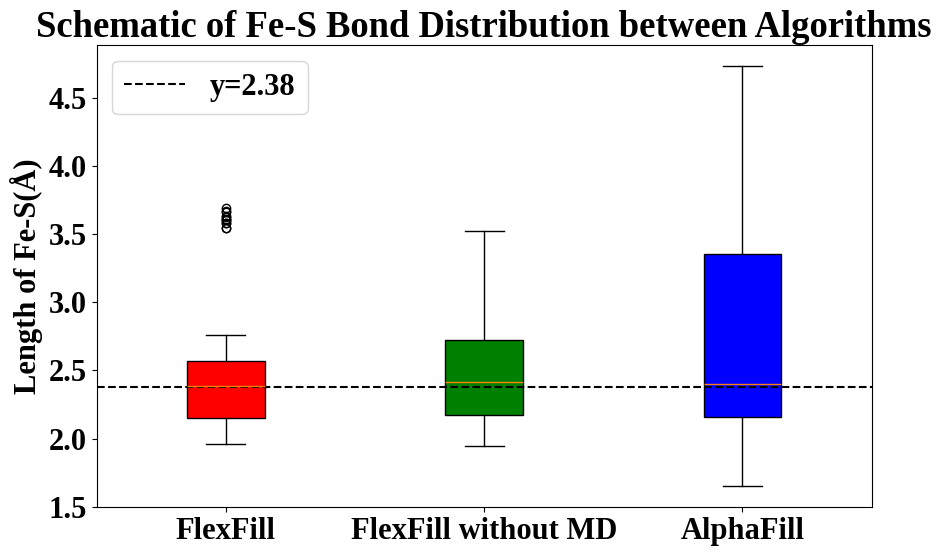

In [57]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import font_manager
#plt.rc('font',family='Times New Roman') 
plt.rcParams['font.family'] = 'Liberation Serif'
import numpy as np


#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

# font_path = './fonts/times.ttf'
# font_prop = font_manager.FontProperties(fname=font_path)
# plt.rcParams['font.family'] = font_prop.get_name()
plt.figure(figsize=(10, 6))

# 生成三组随机数据
data1 = np.random.normal(loc=3, scale=0.5, size=100)
data2 = np.random.normal(loc=6, scale=0.5, size=100)
data3 = np.random.normal(loc=9, scale=0.5, size=100)

# 绘制箱型图，设置 patch_artist=True 以填充颜色
box = plt.boxplot([usfes, cpufes, flfes], patch_artist=True)

# 设置箱子的颜色
colors = ['red', 'green', 'blue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)


plt.axhline(y=2.38, color='black', linestyle='--', label='y=2.38')

plt.title('Schematic of Fe-S Bond Distribution between Algorithms')
#plt.xlabel('a')
plt.ylabel('Length of Fe-S(Å)')
plt.xticks([1, 2, 3], ['FlexFill', 'FlexFill without MD', 'AlphaFill'])

plt.legend()

#plt.savefig('nphoto1600.png', dpi=600, bbox_inches='tight')
# 显示图像
plt.show()


In [48]:
flc1=0
flc2=0
flc3=0
for i in flcra:
    if i==1:
        flc3+=1
    if i>1 and i<=5:
        flc2+=1
    if i>5:
        flc1+=1
flc1=flc1/len(flcra)
flc2=flc2/len(flcra)
flc3=flc3/len(flcra)

In [49]:
usc1=0
usc2=0
usc3=0
for i in uscra:
    if i==1:
        usc3+=1
    if i>1 and i<=5:
        usc2+=1
    if i>5:
        usc1+=1
usc1=usc1/len(uscra)
usc2=usc2/len(uscra)
usc3=usc3/len(uscra)

In [50]:
cpu1=0
cpu2=0
cpu3=0
for i in cpucra:
    if i==1:
        cpu3+=1
    if i>1 and i<=5:
        cpu2+=1
    if i>5:
        cpu1+=1
cpu1=cpu1/len(cpucra)
cpu2=cpu2/len(cpucra)
cpu3=cpu3/len(cpucra)

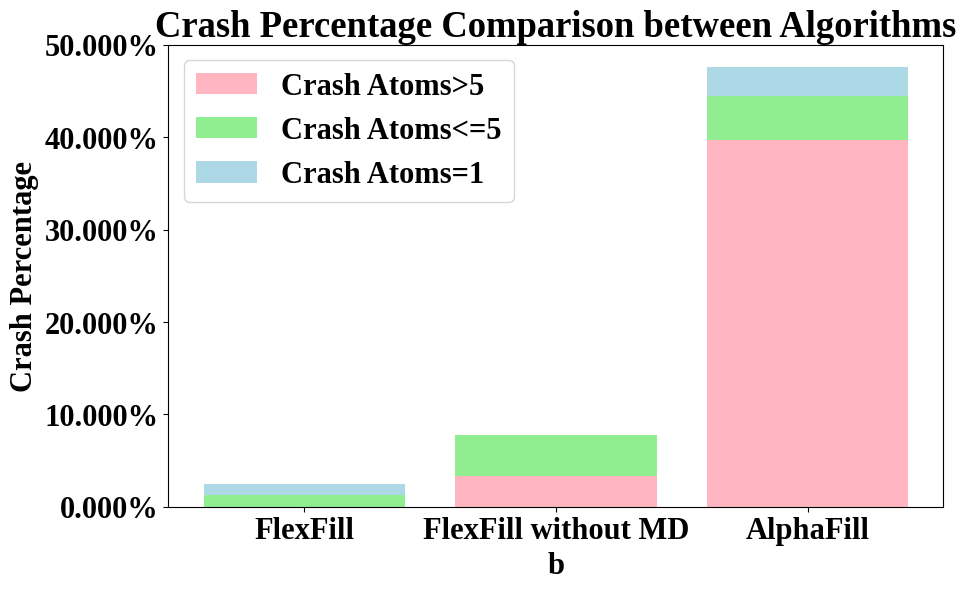

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# 示例数据
# algorithms = ['Algorithm A', 'Algorithm B', 'Algorithm C', 'Algorithm D', 'Our Algorithm']
# crash_type1 = [5, 7, 6, 8, 3]  # 类型1崩溃次数
# crash_type2 = [4, 5, 4, 6, 3]  # 类型2崩溃次数
# crash_type3 = [6, 6, 7, 6, 4]  # 类型3崩溃次数

algorithms = ['FlexFill', 'FlexFill without MD', 'AlphaFill']
crash_type1 = [usc1,cpu1, flc1]  # 类型1崩溃次数
crash_type2 = [usc2,cpu2, flc2]  # 类型2崩溃次数
crash_type3 = [usc3,cpu3, flc3]  # 类型3崩溃次数

print()
# 计算总的崩溃次数
total_crashes = np.array(crash_type1) + np.array(crash_type2) + np.array(crash_type3)

# 将崩溃次数转换为百分比
crash_type1_perc = np.array(crash_type1) / 100
crash_type2_perc = np.array(crash_type2) / 100
crash_type3_perc = np.array(crash_type3) / 100

# 创建堆积条形图
plt.figure(figsize=(10, 6))
bars1 = plt.bar(algorithms, crash_type1_perc, color='lightpink', label='Crash Atoms>5')
bars2 = plt.bar(algorithms, crash_type2_perc, bottom=crash_type1_perc, color='lightgreen', label='Crash Atoms<=5')
bars3 = plt.bar(algorithms, crash_type3_perc, bottom=crash_type1_perc + crash_type2_perc, color='lightblue', label='Crash Atoms=1')

# 添加标签和标题
plt.xlabel('b')
plt.ylabel('Crash Percentage')
plt.title('Crash Percentage Comparison between Algorithms')

# 定义一个函数，将纵坐标的刻度转换为百分数
def to_percent(y, position):
    return f'{10000 * y:.3f}%'

# 使用 FuncFormatter 将纵坐标刻度转换为百分数
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

# 添加图例
plt.legend(loc='upper left')

# 显示图表
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据
algorithms = ['FlexFill', 'FlexFill without\n MD', 'AlphaFill', 'Alphafold3']
run_times = [91,65, 120, 189]  # 运行时间（单位：秒）

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制柱状图
bars = plt.bar(algorithms, run_times, color=['red', 'green', 'blue','yellow'])

# 添加标题和标签
plt.title('Run Time Comparison of Algorithms')
plt.xlabel('c')
plt.ylabel('Run Time (seconds)')

# 显示运行时间在柱状图顶部
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()